# 05. Modelling and evaluation

## Objectives

The purpose of this notebook is to train, evaluate, and interpret machine learning models that predict **CEFR levels** based on learners’ engineered features. Specifically, we aim to:

- Train classification models using the processed dataset (numeric + encoded categorical features).  
- Compare performance across multiple algorithms (e.g., Logistic Regression, Random Forest, Gradient Boosting).  
- Evaluate models using accuracy, precision, recall, F1-score, and confusion matrices to assess reliability.  
- Apply hyperparameter tuning and model refinement to improve predictive performance.  
- Select the best-performing model for deployment and integration into a personalized recommendation system.  
- Save the trained model and evaluation results for reproducibility and downstream use.  

## Inputs

- **Processed dataset**: `data/processed/features.csv`  
  - Contains engineered features (e.g., strongest/weakest skill, skill variance, learning profile, relative differences).  
  - Raw scores have been dropped to prevent data leakage.  
- **Feature matrix (X)**: Scaled numeric features + encoded categorical engineered features.  
- **Target vector (y)**: Encoded CEFR levels (A1–C2).  

## Outputs

- Baseline and advanced trained models.  
- Evaluation metrics (accuracy, precision, recall, F1-score, confusion matrix).  
- Visualizations of model performance and class distribution.  
- Final selected model, serialized (e.g., `model.joblib`) for reuse.  
- Documentation of why the chosen model best supports the **business goal** of automatic learner placement and personalized recommendations.  

## Additional Information

This stage directly addresses the **business requirement**: predicting learners’ CEFR levels to enable **automatic placement** and **tailored learning recommendations**.  
Following the EDA and Feature Engineering steps, only engineered features are used to ensure models generalize fairly without memorizing exam scores.  
By systematically comparing models, tuning hyperparameters, and interpreting feature impacts, we ensure predictions are **accurate, reliable, and explainable** — making them suitable for real-world integration into an adaptive learning platform.  

---

# Project Directory Structure

## Change working directory

We need to change the working directory from its current folder to the folder the code of this project is currently located

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\husse\\OneDrive\\Projects\\lang-level-pred\\jupyter_notebooks'

In [2]:
from pathlib import Path

# swtich to project root directory
project_root = Path.cwd().parent
os.chdir(project_root)
print(f"Working directory: {os.getcwd()}")

Working directory: c:\Users\husse\OneDrive\Projects\lang-level-pred


---

# Data loading
This code block imports fundamental Python libraries for data analysis and visualization and checks their versions

- pandas: For data manipulation and analysis
- numpy: For numerical computations
- matplotlib: For creating visualizations and plots
- seaborn: creating attractive and informative statistical graphics from datasets

The version checks help ensure:
- Code compatibility across different environments
- Reproducibility of analysis
- Easy debugging of version-specific issues

In [3]:
# Import data analysis tools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


print(f"pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")

pandas version: 2.3.1
NumPy version: 2.3.1
matplotlib version: 3.10.5
seaborn version: 0.13.2


### List Files and Folders
- This code shows what files and folders are in our data/clean folder and what folder we are currently in. 

In [5]:
import os
from pathlib import Path

dataset_dir = Path("data/processed")
print(f"[INFO] Files/folders available in {dataset_dir}:")
os.listdir(dataset_dir)

[INFO] Files/folders available in data\processed:


['features.csv', 'target.csv']

## Load Processed Data

In this step, we will load the processed dataset that was prepared in the Feature Engineering Notebook.  
The data has been saved in two separate files:

- `features.csv` → contains the engineered and scaled features.  
- `target.csv` → contains the encoded CEFR levels.  

We will:
- Load both files.  
- Inspect their structure (rows, columns, datatypes).  
- Confirm they align correctly (same number of rows).  
- Prepare them as `X` (features) and `y` (target) for model training.    

In [41]:
import pandas as pd

# Load processed features and target
X = pd.read_csv("data/processed/features.csv")
y = pd.read_csv("data/processed/target.csv").squeeze()  # convert to Series

# ✅ Drop avg_score from features
if "avg_score" in X.columns:
    X = X.drop(columns=["avg_score"])

# Inspect shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Preview
print("\nFeature columns:\n", X.columns.tolist())
print("\nTarget preview:\n", y.head())

# Validate alignment
assert X.shape[0] == y.shape[0], "❌ Row mismatch between features and target!"
print("✅ Features and target aligned correctly.")

Features shape: (1004, 13)
Target shape: (1004,)

Feature columns:
 ['strongest_skill', 'weakest_skill', 'second_weakest_skill', 'skill_std', 'strength_weakness_gap', 'productive_receptive_ratio', 'learning_profile', 'speaking_minus_avg', 'reading_minus_avg', 'listening_minus_avg', 'writing_minus_avg', 'speaking_to_reading', 'writing_to_listening']

Target preview:
 0    0
1    4
2    2
3    2
4    3
Name: cefr_encoded, dtype: int64
✅ Features and target aligned correctly.


---

## 1. Define Features and Target

Now that we have successfully loaded the processed dataset, we need to separate it into:

- **X (features):** all engineered and scaled variables used by the model to make predictions.  
- **y (target):** the encoded CEFR levels that the model will learn to predict.  

We will confirm that both `X` and `y` are correctly structured and aligned before proceeding to train/test splitting.

In [42]:
# Confirm feature matrix (X) and target vector (y)

print("Feature matrix (X):")
print(X.head())

print("\nTarget vector (y):")
print(y.head())

print("\nShapes:")
print("X:", X.shape)
print("y:", y.shape)

Feature matrix (X):
  strongest_skill weakest_skill second_weakest_skill  skill_std  \
0         reading      speaking            listening   1.209576   
1        speaking       writing            listening  -1.273163   
2         reading       writing             speaking   0.219728   
3        speaking     listening            listening   0.270320   
4       listening       reading             speaking   0.352470   

   strength_weakness_gap  productive_receptive_ratio    learning_profile  \
0               1.427690                   -1.584816  Uneven Development   
1              -1.225282                    0.016070            Balanced   
2               0.101204                   -0.943540            Balanced   
3               0.101204                    0.329497            Balanced   
4               0.631798                   -0.107883            Balanced   

   speaking_minus_avg  reading_minus_avg  listening_minus_avg  \
0           -2.069500           1.751171            -0.

## 2. Train/Test Split with One-Hot Encoding

In this step, we:

- Split the dataset into **training** and **testing** sets using stratified sampling to preserve the CEFR class distribution.  
- Identified categorical engineered features:  
  - `strongest_skill`  
  - `weakest_skill`  
  - `second_weakest_skill`  
  - `learning_profile`  
- Identified numeric engineered features:  
  - `skill_std`  
  - `strength_weakness_gap`  
  - `productive_receptive_ratio`  
  - `speaking_minus_avg`  
  - `reading_minus_avg`  
  - `listening_minus_avg`  
  - `writing_minus_avg`  
  - `speaking_to_reading`  
  - `writing_to_listening`  
- Applied **One-Hot Encoding (OHE)** to categorical variables (dropping the first category to avoid multicollinearity).  
- Kept numeric features as-is (passthrough).  
- Verified dataset sizes before and after preprocessing. 

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify categorical and numeric features
categorical_features = ["strongest_skill", "weakest_skill", "second_weakest_skill", "learning_profile"]
numeric_features = [col for col in X.columns if col not in categorical_features]

print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)

# Define preprocessing: One-Hot Encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

# Split the dataset (stratify ensures CEFR balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Fit and transform training set, transform test set
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed training set shape:", X_train_processed.shape)
print("Processed test set shape:", X_test_processed.shape)

Categorical features: ['strongest_skill', 'weakest_skill', 'second_weakest_skill', 'learning_profile']
Numeric features: ['skill_std', 'strength_weakness_gap', 'productive_receptive_ratio', 'speaking_minus_avg', 'reading_minus_avg', 'listening_minus_avg', 'writing_minus_avg', 'speaking_to_reading', 'writing_to_listening']
Training set size: (803, 13)
Test set size: (201, 13)
Processed training set shape: (803, 19)
Processed test set shape: (201, 19)


## 3. Model Training (Baseline)

In this step, we will train an initial **baseline machine learning model** to predict the CEFR level.

- **Why Logistic Regression?**  
  Logistic Regression is a simple, interpretable classifier that works well as a starting point for multi-class classification. It provides a benchmark for accuracy and helps us understand whether more complex models are needed.

- **Process:**
  1. Use the preprocessed feature set (`X_train_processed`, `X_test_processed`).
  2. Train a **Logistic Regression model** with multi-class handling (`multinomial`).
  3. Evaluate performance on the test set using:
     - Accuracy
     - Classification report (precision, recall, F1-score per class)
     - Confusion matrix (to visualize misclassifications)

This baseline performance will serve as a reference point for future, more advanced models.

✅ Logistic Regression Baseline Results
Accuracy: 0.29850746268656714

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.40      0.46        42
           1       0.18      0.16      0.17        44
           2       0.32      0.43      0.37        42
           3       0.32      0.24      0.27        38
           4       0.21      0.26      0.23        19
           5       0.18      0.25      0.21        16

    accuracy                           0.30       201
   macro avg       0.29      0.29      0.29       201
weighted avg       0.31      0.30      0.30       201



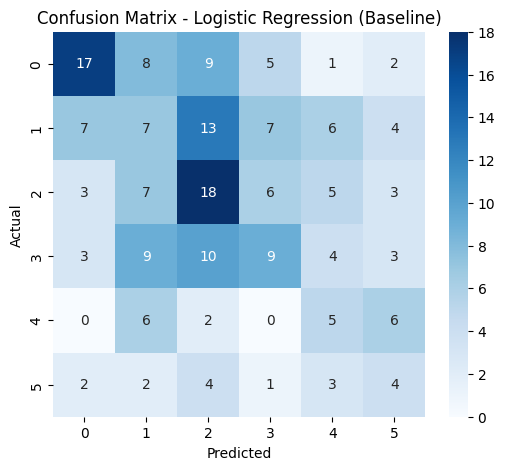

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

# Build pipeline: scaling + logistic regression
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False to work with sparse data from OneHotEncoder
    ("log_reg", LogisticRegression(solver="lbfgs", max_iter=2000, random_state=42))
])

# Train model
log_reg_pipeline.fit(X_train_processed, y_train)

# Predictions
y_pred = log_reg_pipeline.predict(X_test_processed)

# Evaluation
print("✅ Logistic Regression Baseline Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=log_reg_pipeline.named_steps["log_reg"].classes_, 
            yticklabels=log_reg_pipeline.named_steps["log_reg"].classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Baseline)")
plt.show()


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Random Forest pipeline
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight="balanced"
    ))
])

# Train
rf_clf.fit(X_train, y_train)

# Predict
y_pred = rf_clf.predict(X_test)

# Results
print("✅ Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

✅ Random Forest Results
Accuracy: 0.4527363184079602

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.67      0.70        42
           1       0.42      0.39      0.40        44
           2       0.39      0.38      0.39        42
           3       0.42      0.39      0.41        38
           4       0.24      0.32      0.27        19
           5       0.43      0.56      0.49        16

    accuracy                           0.45       201
   macro avg       0.44      0.45      0.44       201
weighted avg       0.46      0.45      0.46       201



In [46]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        use_label_encoder=False,
        eval_metric="mlogloss"
    ))
])

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

print("✅ XGBoost Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

c:\Users\husse\OneDrive\Projects\lang-level-pred\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:45:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Results
Accuracy: 0.5870646766169154

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.76        42
           1       0.52      0.52      0.52        44
           2       0.58      0.60      0.59        42
           3       0.62      0.61      0.61        38
           4       0.36      0.42      0.39        19
           5       0.50      0.56      0.53        16

    accuracy                           0.59       201
   macro avg       0.57      0.57      0.57       201
weighted avg       0.60      0.59      0.59       201

